The dataset we are going to use today is **Boston Dataset**. 

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model
import random
from sklearn import feature_selection
import statsmodels.formula.api as smf
from sklearn import metrics
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing



In [69]:
url = "https://raw.githubusercontent.com/ga-students/SF-DAT-20/master/Data/Boston.csv"
BostonData = pd.read_csv(url)
del BostonData['Unnamed: 0']
BostonData.head(2)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.9,4.98,24.0
1,0.02731,0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.9,9.14,21.6


The Boston data frame has 506 rows and 14 columns.
Usage

Boston

Format

This data frame contains the following columns:

crim

    per capita crime rate by town 
    
zn

    proportion of residential land zoned for lots over 25,000 sq.ft. 
    
indus

    proportion of non-retail business acres per town 
    
chas

    Charles River dummy variable (= 1 if tract bounds river; 0 otherwise) 
    
nox

    nitrogen oxides concentration (parts per 10 million) 
    
rm

    average number of rooms per dwelling 
    
age

    proportion of owner-occupied units built prior to 1940 
    
dis

    weighted mean of distances to five Boston employment centres 
    
rad

    index of accessibility to radial highways 
    
tax

    full-value property-tax rate per 10,000 dollars
    
ptratio

    pupil-teacher ratio by town 
    
black

    1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town 
    
lstat

    lower status of the population (percent) 
    
medv

    median value of owner-occupied homes in 1000 dollars

Source

Harrison, D. and Rubinfeld, D.L. (1978) Hedonic prices and the demand for clean air. J. Environ. Economics and Management 5, 81–102.

Belsley D.A., Kuh, E. and Welsch, R.E. (1980) Regression Diagnostics. Identifying Influential Data and Sources of Collinearity. New York: Wiley.
[Package MASS version 7.2-29 Index]


#### Our goal is to predict the median value of properties (medv) based on other variables in this dataset.

#### First let's draw a scatter-plot of medv and lstat. Intuitively, does it like a pure linear association or it seems like there is some sort of non-linearity?

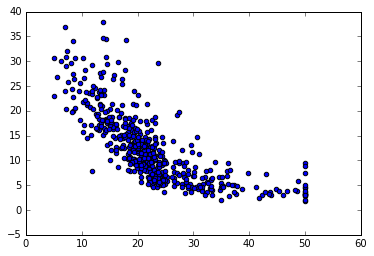

In [70]:
plt.scatter(BostonData.medv,BostonData.lstat)

Answer: It does not look strictly linear.  It looks like there is quadratic or something higher. Diminishing returns to scale

#### Now, let's first define few non-linear terms. Start from a pure linear function and go up to polynomial degree 5. 

In [71]:
BostonData['lstat_2'] = BostonData['lstat']**2
BostonData['lstat_3'] = BostonData['lstat']**3
BostonData['lstat_4'] = BostonData['lstat']**4
BostonData['lstat_5'] = BostonData['lstat']**5
X1 = BostonData[['lstat']]
X2 = BostonData[['lstat','lstat_2']]
X3 = BostonData[['lstat','lstat_2','lstat_3']]
X4 = BostonData[['lstat','lstat_2','lstat_3','lstat_4']]
X5 = BostonData[['lstat','lstat_2','lstat_3','lstat_4','lstat_5']]
y = BostonData['medv']

#### Now divide your dataset into 25% test set and 75% training set and use Validation and MSE of test set to decide which degree of polynomial fits the best. Run this procedure a few times!

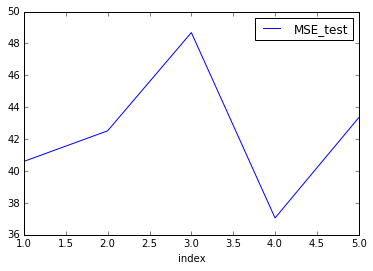

In [72]:
lm = linear_model.LinearRegression()
MSE_test = np.zeros(5)
MSE_train = np.zeros(5)
i = 0
for X in [X1,X2,X3,X4,X5]:
    X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.25)
    #We train based on Training Data BUT will Test on Test Sample
    Model_train = lm.fit(X_train,y_train)
    y_Hat_train = lm.predict(X_train)
    y_Hat_test  = lm.predict(X_test)
    MSE_test[i] = (metrics.mean_squared_error(lm.predict(X_test),y_test))
    MSE_train[i] = (metrics.mean_squared_error(lm.predict(X_train),y_train))
    i += 1

index = np.array(range(5)) + 1
MSE_Test_df = pd.DataFrame({'MSE_test':MSE_test,'index':index})
MSE_Test_df.plot(x = 'index',y= 'MSE_test')
    


Answer: The result will keep changing because of variance so we can
not use validation, we will try cross validation

#### Now, on the same data set, use 10 fold cross-validation to decide on the degree of polynomial. Justify what you find.

[38.830533044001982, 30.779870521376655, 29.45725396663811, 28.321686828827229, 27.760486383232422]


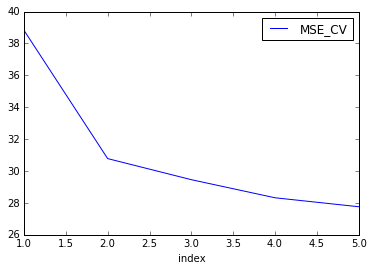

In [73]:
kf = cross_validation.KFold(len(BostonData), n_folds = 10, shuffle = True)
MSE_CV = []

for i in [X1,X2,X3,X4,X5]:
    scores = []
    for train_index, test_index in kf:
        lm = linear_model.LinearRegression().fit(i.iloc[train_index], y.iloc[train_index])
        scores.append(metrics.mean_squared_error(y.iloc[test_index], lm.predict(i.iloc[test_index])))
    MSE_CV.append(np.mean(scores))
        
        
print(MSE_CV)
index = np.array(range(5)) + 1
MSE_CV_df = pd.DataFrame({'MSE_CV':MSE_CV,'index':index})
MSE_CV_df.plot(x = 'index',y= 'MSE_CV')

Answer: He recommends X2, because the improvement does not outweigh the confidence interval issue, but x3 is ok.  According to this analysis, the most fitted model is X5 but using Hamed's advice we would pick either X2 or X3 because he recommends that, to avoid overfitting, it is better to keep the model simple.  Choosing X2 would be choosing the simplest model, but would leave the improvements that the additional features obviously add to the accuracy of the predicted values.  Choosing X3 takes advantage of the additional accuracy.  Besides the "keep it simple" advice, the change in accuracy between the X2 model and the X3 model is greater than the change in accuracy between X3 and X4.  If there had been a more significant increase in accuracy, then it might have been better to choose X4.  

# Now let's consider more variables.

#### Let's first focus on correlation Matrix.

In [74]:
# Let's first get rid of additional variables we added to our dataframe
del BostonData['lstat_2']
del BostonData['lstat_3']
del BostonData['lstat_4']
del BostonData['lstat_5']
BostonData.describe()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677082,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [75]:

BostonData.corr()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
crim,1.000000,-0.200469,0.406583,-0.055892,0.420972,-0.219247,0.352734,-0.379670,0.625505,0.582764,0.289946,-0.385064,0.455621,-0.388305
zn,-0.200469,1.000000,-0.533828,-0.042697,-0.516604,0.311991,-0.569537,0.664408,-0.311948,-0.314563,-0.391679,0.175520,-0.412995,0.360445
indus,0.406583,-0.533828,1.000000,0.062938,0.763651,-0.391676,0.644779,-0.708027,0.595129,0.720760,0.383248,-0.356977,0.603800,-0.483725
chas,-0.055892,-0.042697,0.062938,1.000000,0.091203,0.091251,0.086518,-0.099176,-0.007368,-0.035587,-0.121515,0.048788,-0.053929,0.175260
nox,0.420972,-0.516604,0.763651,0.091203,1.000000,-0.302188,0.731470,-0.769230,0.611441,0.668023,0.188933,-0.380051,0.590879,-0.427321
rm,-0.219247,0.311991,-0.391676,0.091251,-0.302188,1.000000,-0.240265,0.205246,-0.209847,-0.292048,-0.355501,0.128069,-0.613808,0.695360
age,0.352734,-0.569537,0.644779,0.086518,0.731470,-0.240265,1.000000,-0.747881,0.456022,0.506456,0.261515,-0.273534,0.602339,-0.376955
dis,-0.379670,0.664408,-0.708027,-0.099176,-0.769230,0.205246,-0.747881,1.000000,-0.494588,-0.534432,-0.232471,0.291512,-0.496996,0.249929
rad,0.625505,-0.311948,0.595129,-0.007368,0.611441,-0.209847,0.456022,-0.494588,1.000000,0.910228,0.464741,-0.444413,0.488676,-0.381626
tax,0.582764,-0.314563,0.720760,-0.035587,0.668023,-0.292048,0.506456,-0.534432,0.910228,1.000000,0.460853,-0.441808,0.543993,-0.468536


#### List 3 variables that have the highest chance to appear in your final model - the model that can predict medv. Can these variables appear simultaneously in your final model if your goal is interpretation?

Answer: lstat (% lower economic status), ptratio (pupil teacher ratio), rm (number of rooms per dwelling) -- lstat and rm  have a strong negative correlation  (more than .3 is highly correlated)

#### Now let's standardize our data and put it in a new DataFrame called BostonDataNew

In [76]:
BostonDataNew = preprocessing.scale(BostonData) #BostonDataNew is now a numpy array
BostonDataNew = pd.DataFrame(BostonDataNew)   #We changed BostonDataNew to a dataframe
BostonDataNew.columns = BostonData.columns.values  #We renamed columns of CreditDataNew
BostonDataNew.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,-0.419782,0.284830,-1.287909,-0.272599,-0.144217,0.413672,-0.120013,0.140214,-0.982843,-0.666608,-1.459000,0.441052,-1.075562,0.159686
1,-0.417339,-0.487722,-0.593381,-0.272599,-0.740262,0.194274,0.367166,0.557160,-0.867883,-0.987329,-0.303094,0.441052,-0.492439,-0.101524
2,-0.417342,-0.487722,-0.593381,-0.272599,-0.740262,1.282714,-0.265812,0.557160,-0.867883,-0.987329,-0.303094,0.396427,-1.208727,1.324247
3,-0.416750,-0.487722,-1.306878,-0.272599,-0.835284,1.016303,-0.809889,1.077737,-0.752922,-1.106115,0.113032,0.416163,-1.361517,1.182758
4,-0.412482,-0.487722,-1.306878,-0.272599,-0.835284,1.228577,-0.511180,1.077737,-0.752922,-1.106115,0.113032,0.441052,-1.026501,1.487503


#### Now let's use 10-fold cross validation and Lasso regression on our standardized data to decide which variables to eliminate.

In [88]:
listOfAllVariables = BostonDataNew.columns.values
print listOfAllVariables
X = BostonDataNew[listOfAllVariables]
del X['medv']
#del X['lstat_2']
y = BostonDataNew['medv']
BostonDataNew.corr()

['crim' 'zn' 'indus' 'chas' 'nox' 'rm' 'age' 'dis' 'rad' 'tax' 'ptratio'
 'black' 'lstat' 'medv']


,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
crim,1.000000,-0.200469,0.406583,-0.055892,0.420972,-0.219247,0.352734,-0.379670,0.625505,0.582764,0.289946,-0.385064,0.455621,-0.388305
zn,-0.200469,1.000000,-0.533828,-0.042697,-0.516604,0.311991,-0.569537,0.664408,-0.311948,-0.314563,-0.391679,0.175520,-0.412995,0.360445
indus,0.406583,-0.533828,1.000000,0.062938,0.763651,-0.391676,0.644779,-0.708027,0.595129,0.720760,0.383248,-0.356977,0.603800,-0.483725
chas,-0.055892,-0.042697,0.062938,1.000000,0.091203,0.091251,0.086518,-0.099176,-0.007368,-0.035587,-0.121515,0.048788,-0.053929,0.175260
nox,0.420972,-0.516604,0.763651,0.091203,1.000000,-0.302188,0.731470,-0.769230,0.611441,0.668023,0.188933,-0.380051,0.590879,-0.427321
rm,-0.219247,0.311991,-0.391676,0.091251,-0.302188,1.000000,-0.240265,0.205246,-0.209847,-0.292048,-0.355501,0.128069,-0.613808,0.695360
age,0.352734,-0.569537,0.644779,0.086518,0.731470,-0.240265,1.000000,-0.747881,0.456022,0.506456,0.261515,-0.273534,0.602339,-0.376955
dis,-0.379670,0.664408,-0.708027,-0.099176,-0.769230,0.205246,-0.747881,1.000000,-0.494588,-0.534432,-0.232471,0.291512,-0.496996,0.249929
rad,0.625505,-0.311948,0.595129,-0.007368,0.611441,-0.209847,0.456022,-0.494588,1.000000,0.910228,0.464741,-0.444413,0.488676,-0.381626
tax,0.582764,-0.314563,0.720760,-0.035587,0.668023,-0.292048,0.506456,-0.534432,0.910228,1.000000,0.460853,-0.441808,0.543993,-0.468536


Alpha: 1e-10 0.284776127381
Alpha: 1e-09 0.284776127081
Alpha: 1e-08 0.284776124071
Alpha: 1e-07 0.284776094077
Alpha: 1e-06 0.284775793332
Alpha: 1e-05 0.284772798881
Alpha: 0.0001 0.284742148692
Alpha: 0.001 0.284458912486
Alpha: 0.01 0.287973732266
Alpha: 0.1 0.346597594719
Alpha: 1.0 1.00243049918
Alpha: 10.0 1.00243049918
Alpha: 100.0 1.00243049918
Alpha: 1000.0 1.00243049918
Alpha: 10000.0 1.00243049918
Alpha: 100000.0 1.00243049918
Alpha: 1000000.0 1.00243049918
Alpha: 10000000.0 1.00243049918
Alpha: 100000000.0 1.00243049918
Alpha: 1000000000.0 1.00243049918
Alpha: 10000000000.0 1.00243049918


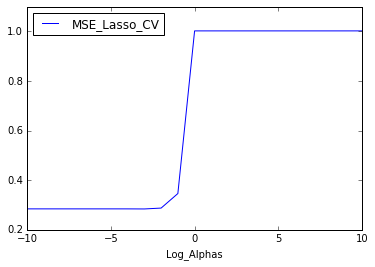

In [78]:
kf = cross_validation.KFold(len(BostonDataNew), n_folds = 10, shuffle = True)
MSE_Lasso_CV = []
alphas = np.logspace(-10, 10, 21) #this is the lambda
alphas_index = np.linspace(-10,10,21)
scores = []
for a in alphas:
    
    scores = []
    for train_index, test_index in kf:
        lm = linear_model.Lasso(alpha=a).fit(X.iloc[train_index], y.iloc[train_index])
        scores.append(metrics.mean_squared_error(y.iloc[test_index], lm.predict(X.iloc[test_index])))
    print 'Alpha:', a, np.mean(scores)
    MSE_Lasso_CV.append(np.mean(scores))



index = alphas
MSE_Lasso_CV_df = pd.DataFrame({'MSE_Lasso_CV': MSE_Lasso_CV ,'Log_Alphas': alphas_index })
MSE_Lasso_CV_df.plot(x = 'Log_Alphas',y = 'MSE_Lasso_CV')

In [93]:
lm = linear_model.Lasso(alpha=10**(-1))
lm.fit(X, y)
print zip(lm.coef_,X.columns)

[(-0.0, 'crim'), (0.0, 'zn'), (-0.0, 'indus'), (0.0073948593720603436, 'chas'), (-0.0, 'nox'), (0.30018561075517203, 'rm'), (-0.0, 'age'), (-0.0, 'dis'), (-0.0, 'rad'), (-0.0, 'tax'), (-0.15076235514591588, 'ptratio'), (0.026239609395646346, 'black'), (-0.38700973619760282, 'lstat')]


Answer: Choose rm or lstat due to high collinearity and also choose ptratio 

#### Now let's use 10-fold cross validation to choose our best model among the following candidates. Let's first add lstat**2 to our model. 

In [80]:
BostonData['lstat_2'] = BostonData['lstat']**2
X1 = BostonData[['lstat']]
X2 = BostonData[['lstat','lstat_2']]
X3 = BostonData[['lstat','chas']]
X4 = BostonData[['lstat','lstat_2','chas']] #'black' is highly correlated with lstat so cannot consider them simoltanously
X5 = BostonData[['ptratio','chas']]
X6 = BostonData[['ptratio','chas','black']]
X7 = BostonData[['ptratio','black']]
X8 = BostonData[['rm']]
X9 = BostonData[['rm','chas']]
X10 = BostonData[['rm','chas','black']]
X11 = BostonData[['rm','black']]
X12 = BostonData[['lstat','ptratio','rm']]  #model without that much interpretability
X13 = BostonData[['lstat','lstat_2','ptratio','rm']]  #model without that much interpretability
X14 = BostonData[['lstat','ptratio','rm','chas','black']]  #model without that much interpretability
X15 = BostonData[['lstat','lstat_2','ptratio','rm','chas','black']]  #model without that much interpretability
y = BostonData['medv']

In [81]:
kf = cross_validation.KFold(len(BostonDataNew), n_folds = 10, shuffle = True)
MSE_alpha_CV = []
alphas = np.logspace(-10, 10, 21) #this is the lambda
alphas_index = np.linspace(-10,10,21)
scores = []
MSE_alpha_CV_df = pd.DataFrame({'log_alpha': alphas_index })


MSE_CV = []
j=0

for i in [X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15]:
    for a in alphas:
        scores = []
        for train_index, test_index in kf:
            lm = linear_model.Lasso(alpha=a).fit(i.iloc[train_index], y.iloc[train_index])
            scores.append(metrics.mean_squared_error(y.iloc[test_index], lm.predict(i.iloc[test_index])))
        #print 'Alpha:', a, np.mean(scores)
        MSE_CV.append(np.mean(scores))
    j=j+1
    MSE_alpha_CV_df[j] = MSE_CV
    MSE_CV = []
    
MSE_alpha_CV_df
    



,log_alpha,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,-10,38.943519,30.850695,37.563690,29.543467,62.690436,57.584382,57.993379,44.963780,44.252340,39.511537,40.154070,28.329386,24.107797,27.329114,23.103806
1,-9,38.943519,30.850695,37.563690,29.543467,62.690436,57.584382,57.993379,44.963780,44.252340,39.511537,40.154070,28.329386,24.107797,27.329114,23.103806
2,-8,38.943519,30.850695,37.563690,29.543467,62.690436,57.584382,57.993379,44.963780,44.252340,39.511537,40.154070,28.329386,24.107797,27.329114,23.103806
3,-7,38.943519,30.850695,37.563690,29.543467,62.690436,57.584382,57.993379,44.963780,44.252340,39.511537,40.154070,28.329386,24.107797,27.329114,23.103806
4,-6,38.943519,30.850695,37.563690,29.543467,62.690436,57.584382,57.993379,44.963780,44.252340,39.511537,40.154070,28.329386,24.107797,27.329113,23.103805
5,-5,38.943519,30.850695,37.563689,29.543466,62.690433,57.584380,57.993378,44.963780,44.252339,39.511535,40.154072,28.329383,24.107795,27.329108,23.103801
6,-4,38.943519,30.850689,37.563688,29.543458,62.690413,57.584361,57.993376,44.963779,44.252323,39.511511,40.154057,28.329364,24.107772,27.329060,23.103760
7,-3,38.943517,30.850637,37.563690,29.543391,62.690229,57.584185,57.993383,44.963766,44.252183,39.511332,40.153910,28.329124,24.107546,27.328588,23.103368
8,-2,38.943499,30.850135,37.565186,29.544217,62.689860,57.583921,57.993468,44.963819,44.252356,39.511023,40.152627,28.327302,24.105559,27.326105,23.101142
9,-1,38.943491,30.847745,37.727249,29.702176,62.833684,57.729364,57.996308,44.982588,44.411637,39.666628,40.158412,28.336252,24.113045,27.469858,23.248340


In [82]:
j=1
for i in [X1,X2]:
    lm = linear_model.Lasso(alpha=10**(-1))
    lm.fit(i, y)
    print j, zip(lm.coef_,i.columns),metrics.mean_squared_error(y.iloc[test_index], lm.predict(i.iloc[test_index]))
    j=j+1
    print ''

for i in [X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15]:
    lm = linear_model.Lasso(alpha=10**(-2))
    lm.fit(i, y)
    print j, zip(lm.coef_,i.columns),metrics.mean_squared_error(y.iloc[test_index], lm.predict(i.iloc[test_index]))
    j=j+1
    print ''
    
# programming tasks:  how to get sorted list of mean square error with model number as index
# how to create index with model name "X1" etc 

1 [(-0.94808448480347485, 'lstat')] 46.9676352359

2 [(-2.306062811650615, 'lstat'), (0.042767546633610036, 'lstat_2')] 35.7078085105

3 [(-0.9407138415358498, 'lstat'), (4.7645075485562529, 'chas')] 45.020066274

4 [(-2.3128099296640889, 'lstat'), (0.043200611574037817, 'lstat_2'), (4.5954845913289102, 'chas')] 35.258174559

5 [(-2.0977544395698824, 'ptratio'), (4.0180983544101876, 'chas')] 76.4641768491

6 [(-1.914079383901647, 'ptratio'), (3.7694246158880995, 'chas'), (0.025028776673082582, 'black')] 75.8605906634

7 [(-1.9656178848017449, 'ptratio'), (0.025323629719331463, 'black')] 75.4726735012

8 [(9.0818124577463042, 'rm')] 54.6538330615

9 [(8.9521374262004638, 'rm'), (3.9310912165277627, 'chas')] 53.9227940641

10 [(8.5524883832883276, 'rm'), (3.5992804499034636, 'chas'), (0.024673693003422568, 'black')] 52.8752263285

11 [(8.6649424934194812, 'rm'), (0.025051405866932854, 'black')] 53.1914932379

12 [(-0.57352322767091468, 'lstat'), (-0.9299712840829113, 'ptratio'), (4.48523

#### If your goal is interpretation - what model(s) are you going to use? Use  smf.ols  in "statsmodels.formula.api as smf" to test significancy of your coefficients. 

Answer: don't understand what makes these more interpretable than the last set...

In [83]:
for i in [X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11]:
    lm1 = smf.ols(formula='y ~ i', data=BostonData).fit()
    print(lm1.summary())

    


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     601.6
Date:                Mon, 22 Feb 2016   Prob (F-statistic):           5.08e-88
Time:                        19:22:29   Log-Likelihood:                -1641.5
No. Observations:                 506   AIC:                             3287.
Df Residuals:                     504   BIC:                             3295.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     34.5538      0.563     61.415      0.0

#### If your goal is prediction - what model(s) are you going to use? Use  smf.ols  in "statsmodels.formula.api as smf" to test significancy of your coefficients. 

Answer: model 1 : lstat, model 8 or 9: rm & chas

In [84]:
for i in [X12,X13,X14,X15]:
    lm1 = smf.ols(formula='y ~ i', data=BostonDataNew).fit()
    print(lm1.summary())
    
    #All of our models are highly significant, so we use model 15. It generates the least CV-MSE. 

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.679
Model:                            OLS   Adj. R-squared:                  0.677
Method:                 Least Squares   F-statistic:                     353.3
Date:                Mon, 22 Feb 2016   Prob (F-statistic):          2.69e-123
Time:                        19:22:29   Log-Likelihood:                -1553.0
No. Observations:                 506   AIC:                             3114.
Df Residuals:                     502   BIC:                             3131.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     18.5671      3.913      4.745      0.0